In [1]:
import gym,time
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from keras import backend as K
from keras.layers import Dense, Activation, Input
from keras.models import Model, load_model
from keras.optimizers import Adam
from IPython.display import clear_output

from sklearn.neural_network import MLPRegressor
from warnings import filterwarnings
filterwarnings('ignore')


import seaborn as sns
sns.set_context("paper")
sns.set_style("darkgrid")

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Using TensorFlow backend.


In [2]:
env=gym.make("InvertedPendulum-v2")
#env._max_episode_steps=500
env.reset()
state_dim = env.observation_space.shape
lower_bound_action,upper_bound_action=env.action_space.low,env.action_space.high
n_actions = lower_bound_action.shape[0]

In [3]:
class Actor(nn.Module):
    def __init__(self,paras):
        super(Actor, self).__init__()
        self.input_dim=paras['dim_state']
        self.output_dim=paras['num_action']
        self.alpha_actor=paras['alpha_actor']
        self.structure_actor=paras['structure_actor']
        
        self.structure=[]
        for idx,layer in enumerate(self.structure_actor[:-1]):
            if idx==0:
                self.structure.append(nn.Linear(self.input_dim,layer))
                self.structure.append(nn.Linear(layer,self.structure_actor[idx+1]))
            else:
                self.structure.append(nn.Linear(layer,self.structure_actor[idx+1]))
        self.structure.append([nn.Linear(self.structure_actor[-1],self.output_dim),nn.Linear(self.structure_actor[-1],self.output_dim)])
        self.myparameters=nn.ModuleList(self.structure[:-1]+[self.structure[-1][0],self.structure[-1][0]])
        self.optimizer = optim.Adam(self.parameters(), lr=self.alpha_actor)
        
    def forward(self, x):
        x = T.tensor(x, dtype=T.float)
        for idx,layer in enumerate(self.structure[:-1]):
            x=F.relu(layer(x))
        mu=self.structure[-1][0](x)
        sigma=T.exp(self.structure[-1][1](x))
        return mu,sigma

In [4]:
class A2C(object):
    def __init__(self,paras={}):
        self.dim_state=paras['dim_state']
        self.num_action=paras['num_action']
        self.lower_bound_action=paras['lower_bound_action']
        self.upper_bound_action=paras['upper_bound_action']
        
        self.gamma=0.99999
        self.actor=Actor(paras)
        self.critic=self.Critic(paras)
        
    def Critic(self,paras):
        state = Input(shape=[self.dim_state,])
        for idx,layer in enumerate(paras['structure_critic']):
            if idx==0:
                dense_layers = [Dense(layer, activation='relu')(state)]
            else:
                dense_layers.append(Dense(layer, activation='relu')(dense_layers[-1]))
        value = Dense(1, activation='linear')(dense_layers[-1])
        critic = Model(inputs=[state], outputs=[value])
        critic.compile(optimizer=Adam(lr=paras['alpha_critic']), loss="mse")
        return critic
    
    def get_actions(self,s):
        mu,sigma=self.actor.forward(s)
        mu=mu.detach().numpy()
        sigma=sigma.detach().numpy()
        a=np.random.normal(mu,sigma)  
        a=np.clip(a,self.lower_bound_action,self.upper_bound_action)
        return a 
    
    def update_paras(self,s,a,r,sp,done,gamma):
        v_s=self.critic.predict(s)
        v_sp=self.critic.predict(sp)
        target=r+self.gamma*v_sp*(not done)
        delta=target-v_s
        self.critic.fit(s,target,verbose=False)
        
        delta*=gamma
        mu,sigma=self.actor.forward(s)
        action_probs = T.distributions.Normal(mu, sigma)
        a = T.tensor(a, dtype=T.float)
        delta = T.tensor(delta, dtype=T.float)
        log_probs = action_probs.log_prob(a)        
        self.actor_loss = -log_probs*delta
        self.actor.optimizer.zero_grad()
        self.actor_loss.sum().backward()
        self.actor.optimizer.step()

In [5]:
agent_config={}
agent_config['dim_state']=state_dim[0]
agent_config['num_action']=n_actions
agent_config['lower_bound_action']=lower_bound_action
agent_config['upper_bound_action']=upper_bound_action
agent_config['alpha_actor']=1e-6
agent_config['structure_actor']=[256,128]
agent_config['alpha_critic']=1e-3
agent_config['structure_critic']=[256,128]
agent=A2C(agent_config)

50 8.12


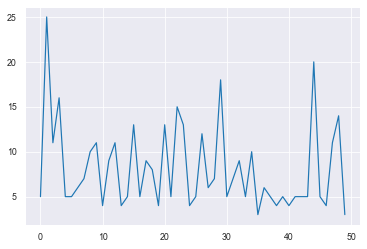

100 7.62


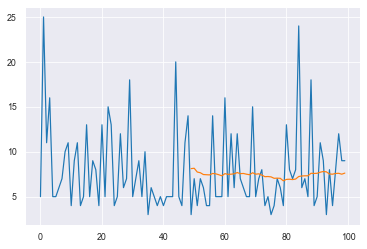

150 7.48


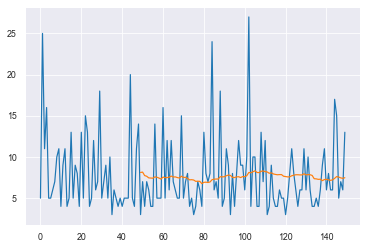

200 7.42


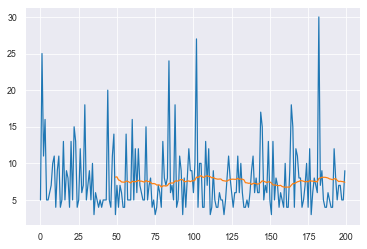

250 7.46


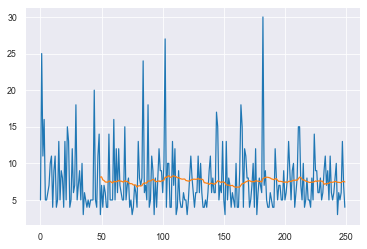

300 7.76


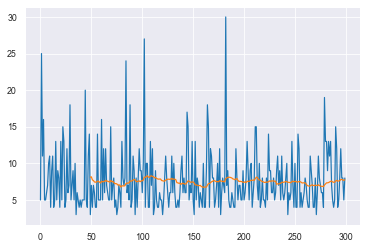

350 7.42


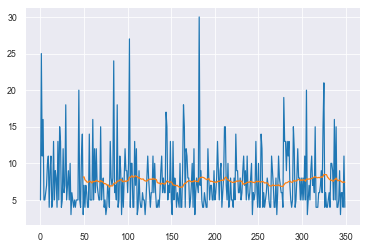

400 8.18


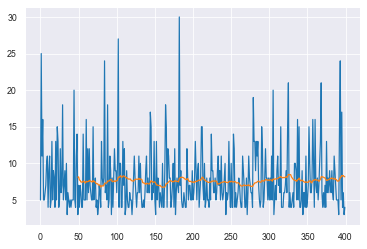

450 7.98


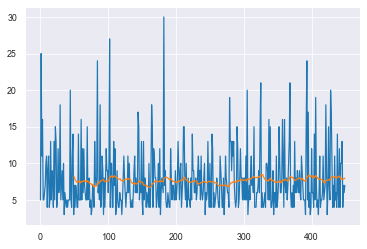

500 7.58


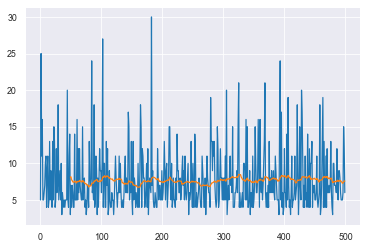

550 7.98


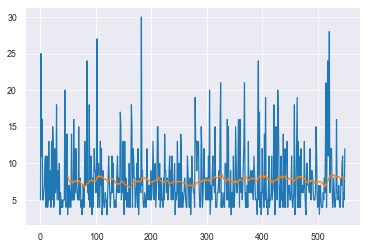

600 8.38


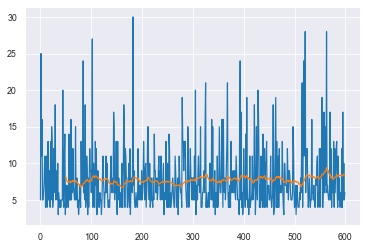

650 9.58


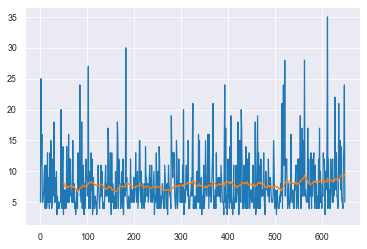

700 9.28


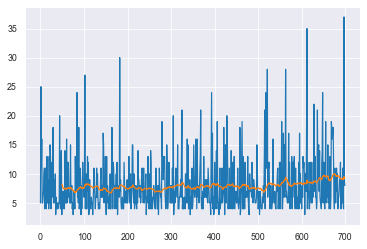

750 9.8


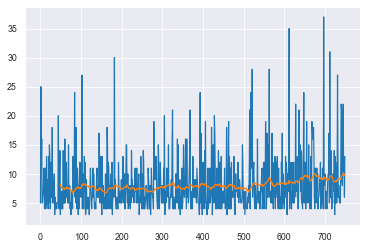

800 9.9


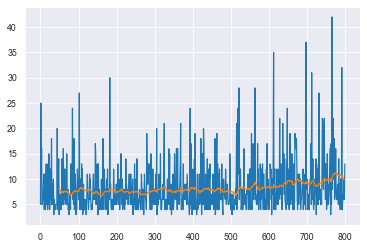

850 8.7


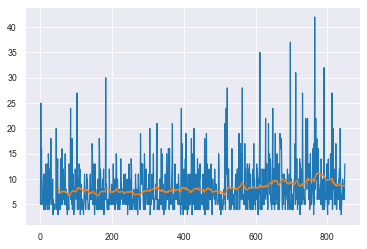

900 9.58


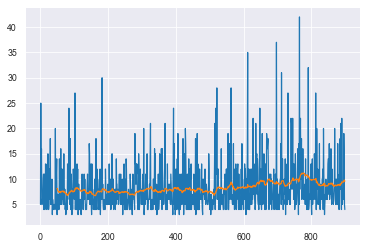

950 8.12


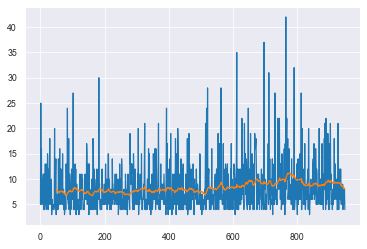

1000 8.04


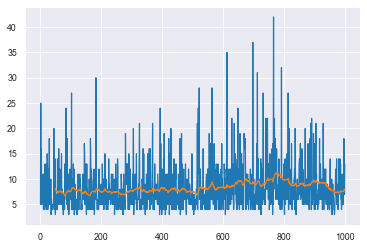

1050 11.42


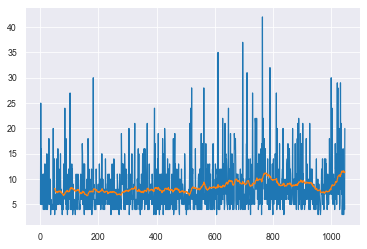

1100 9.5


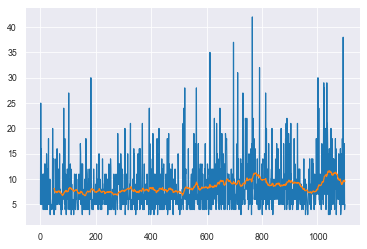

1150 9.72


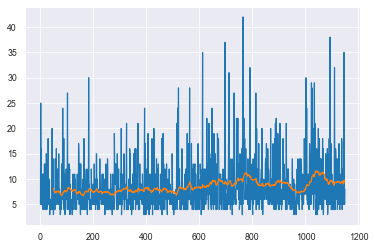

1200 10.84


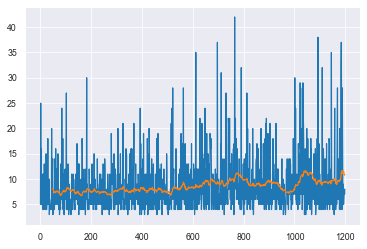

1250 11.6


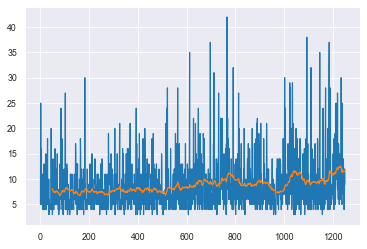

1300 10.66


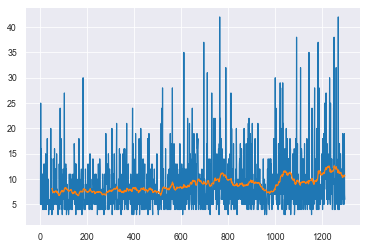

1350 9.84


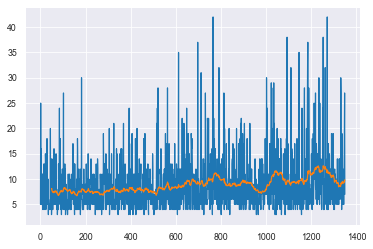

1400 9.8


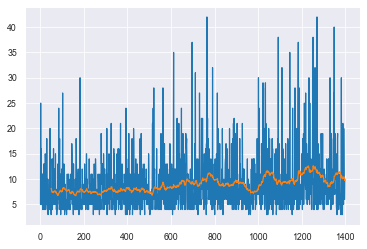

1450 10.4


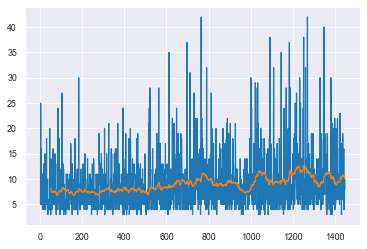

1500 10.58


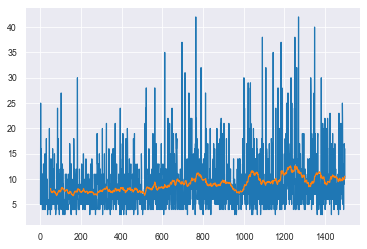

1550 10.34


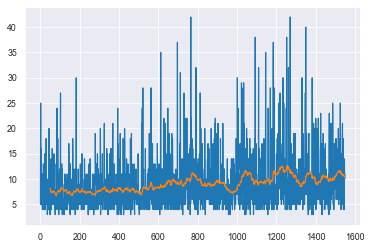

1600 11.2


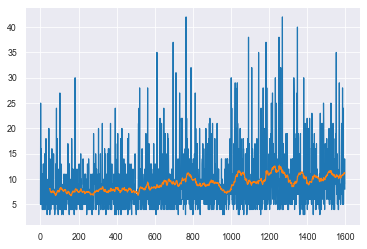

1650 10.88


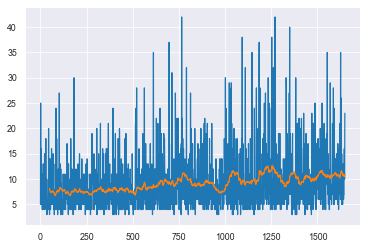

1700 13.02


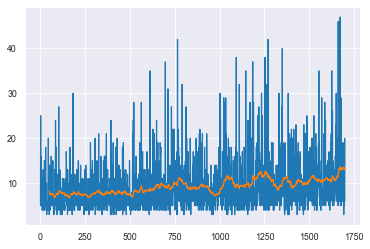

1750 11.84


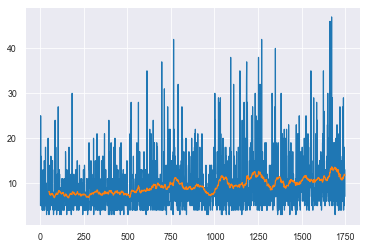

1800 11.82


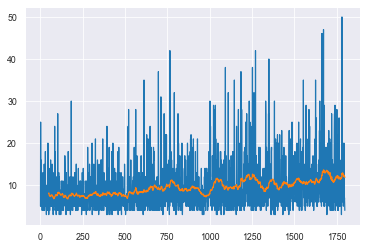

1850 11.7


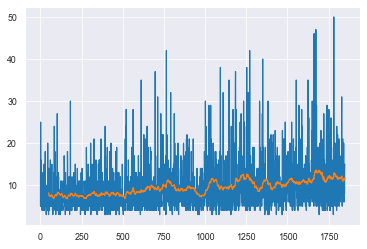

1900 13.5


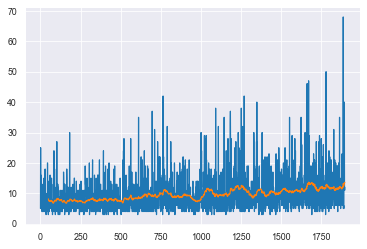

1950 13.38


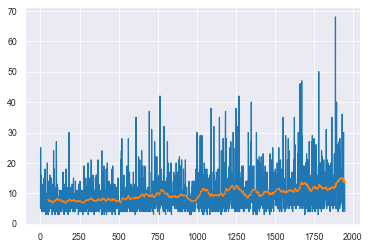

2000 10.48


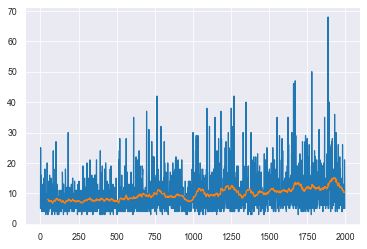

2050 13.54


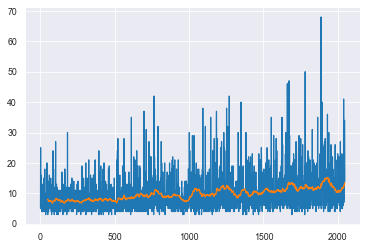

2100 12.76


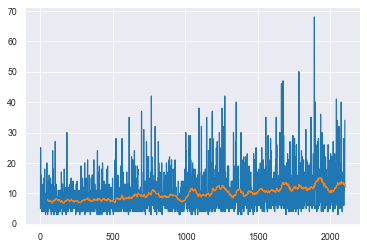

2150 12.88


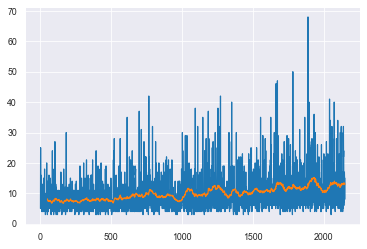

2200 11.7


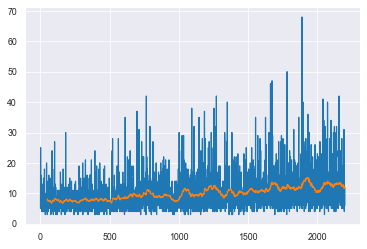

2250 13.72


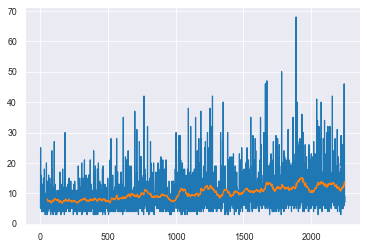

2300 16.72


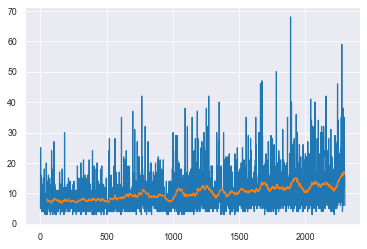

2350 13.56


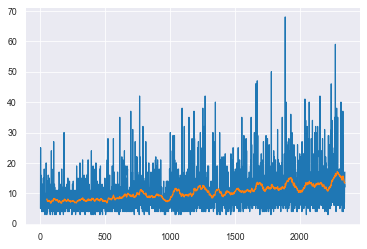

2400 13.06


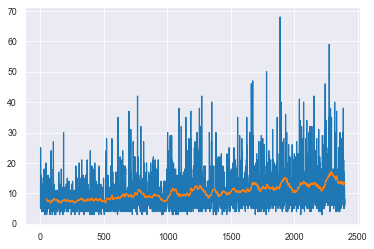

2450 15.7


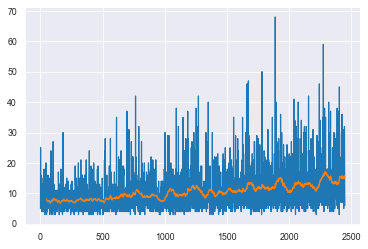

2500 15.46


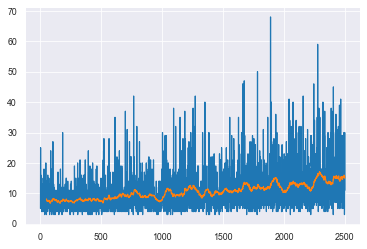

2550 15.16


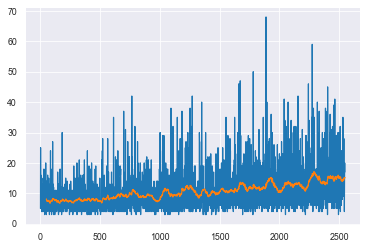

2600 17.24


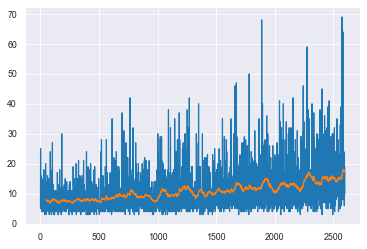

2650 14.76


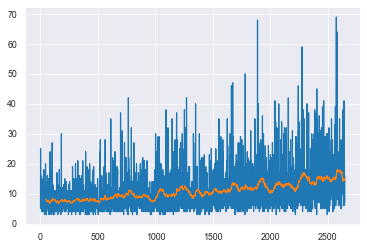

2700 13.48


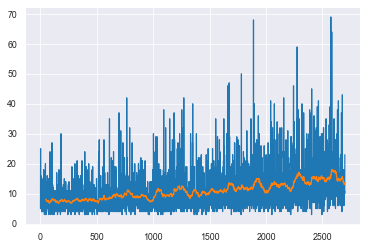

2750 15.9


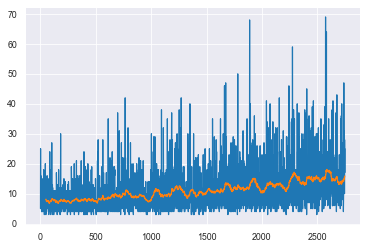

2800 16.2


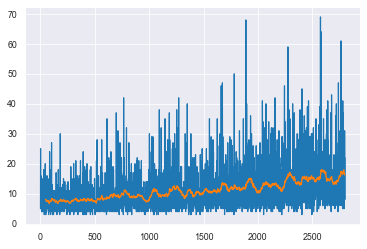

2850 15.94


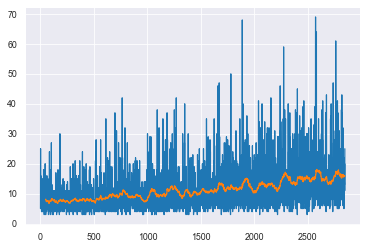

2900 16.54


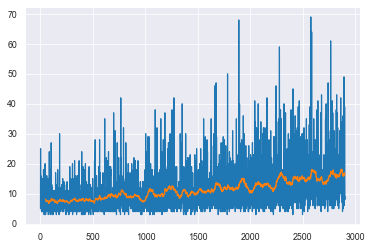

2950 18.26


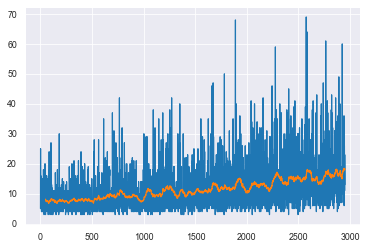

3000 14.1


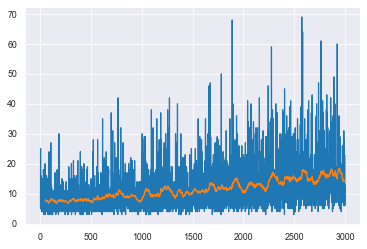

3050 16.42


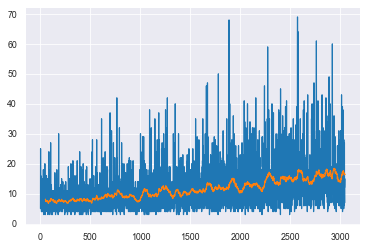

3100 17.12


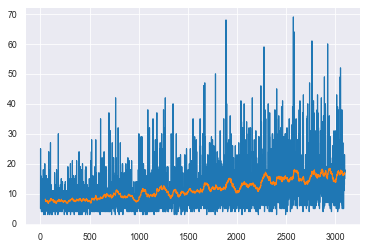

3150 19.68


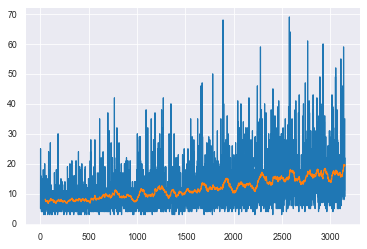

3200 17.36


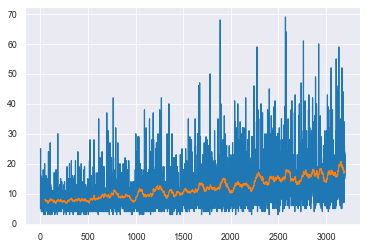

3250 20.06


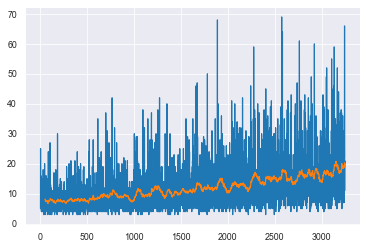

3300 22.38


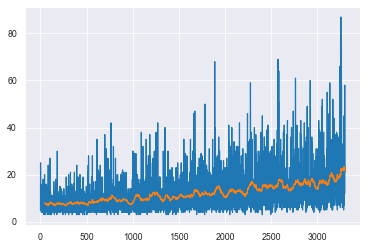

3350 18.62


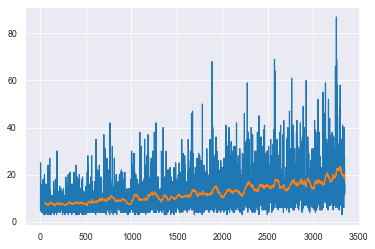

3400 20.36


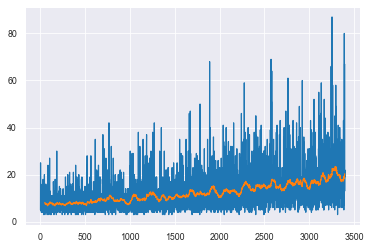

3450 21.2


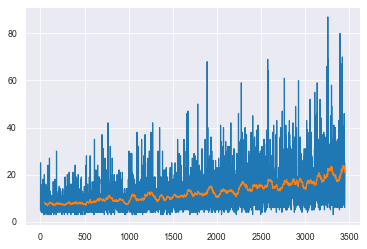

3500 20.76


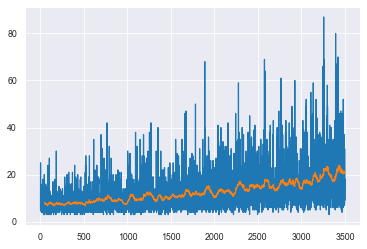

3550 22.64


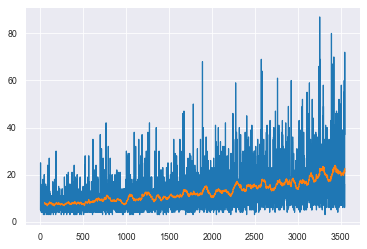

3600 22.22


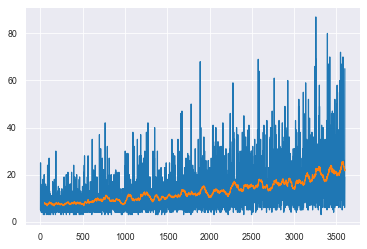

3650 24.58


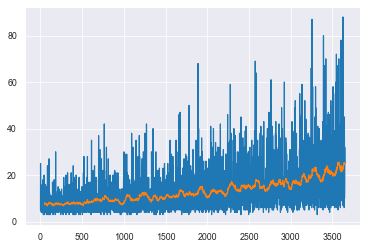

3700 26.64


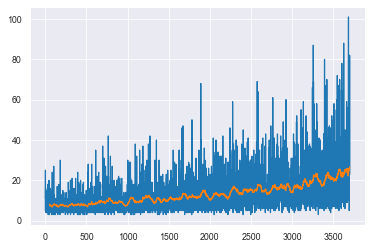

3750 22.64


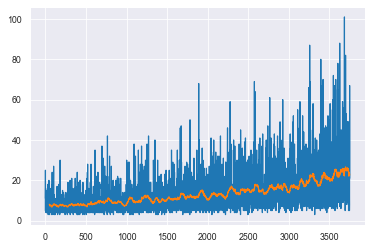

3800 23.44


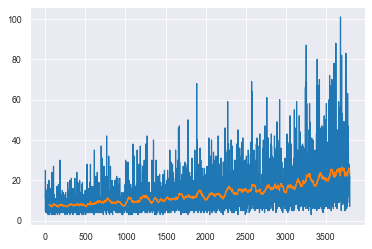

3850 25.56


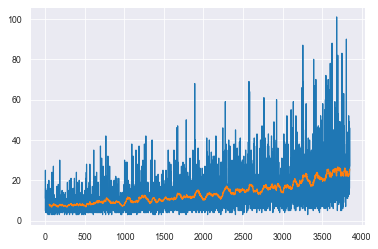

3900 23.42


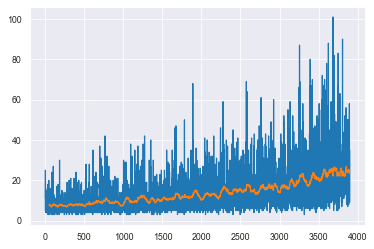

3950 23.56


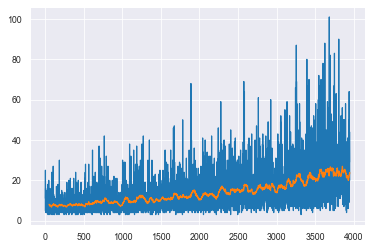

4000 28.4


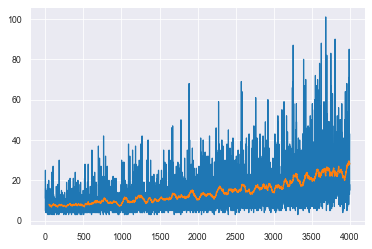

4050 31.5


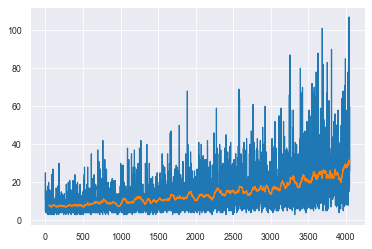

4100 28.6


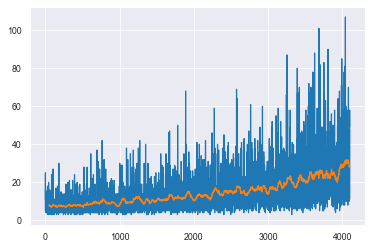

4150 28.46


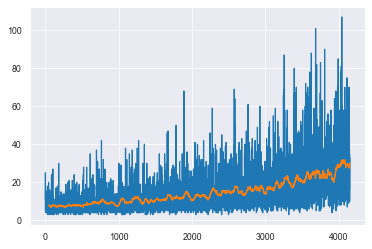

4200 31.96


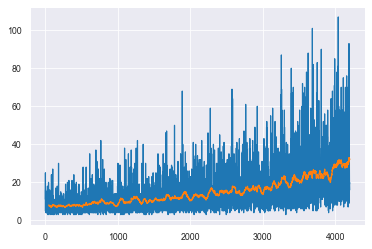

4250 32.26


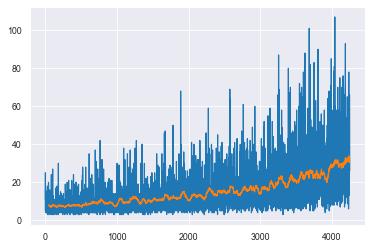

4300 29.34


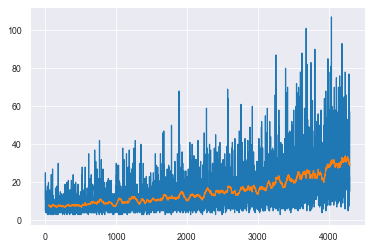

4350 34.7


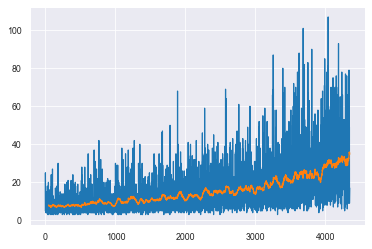

4400 34.02


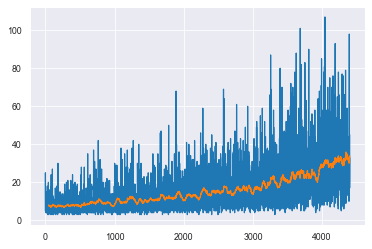

4450 34.88


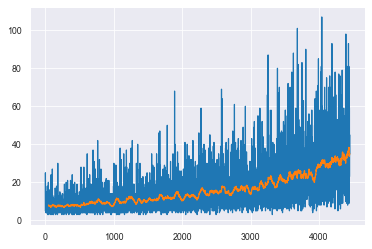

4500 42.14


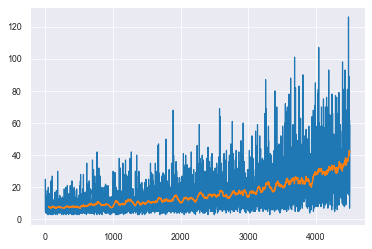

4550 37.28


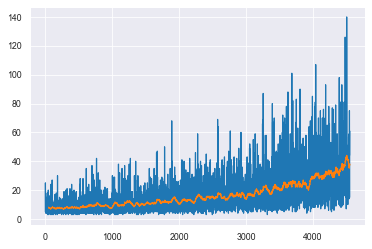

4600 34.76


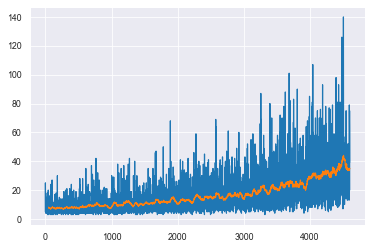

4650 45.92


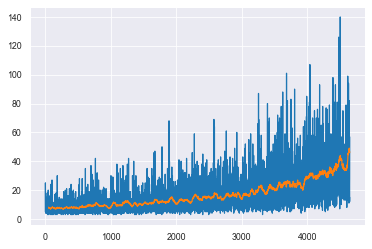

4700 44.06


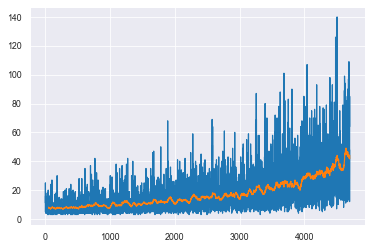

4750 37.64


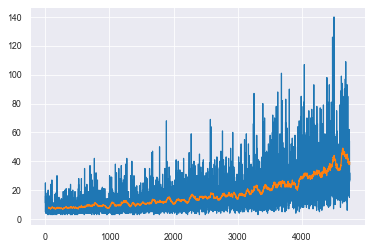

4800 48.88


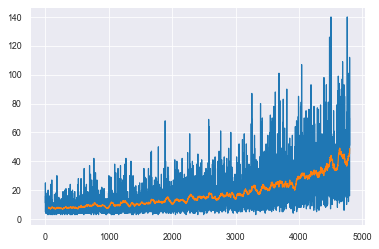

4850 48.58


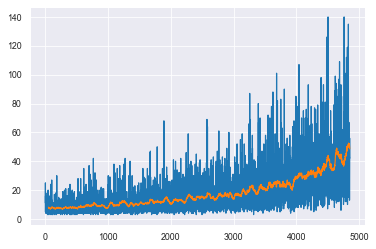

4900 51.38


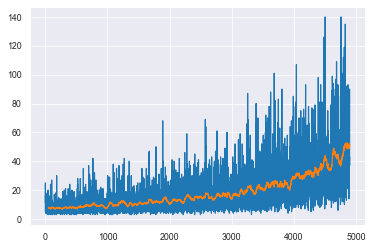

4950 54.98


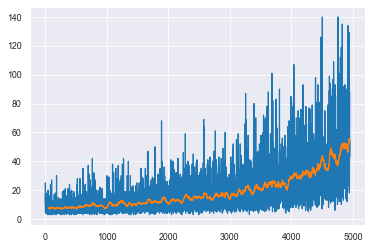

5000 58.2


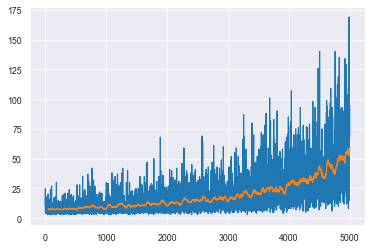

In [6]:
Iter=5000
G_log=[]
for epoch in range(Iter):
    done=False
    s=env.reset()
    G=0
    gamma=1
    while not done:
        a = agent.get_actions(s.reshape(1,-1))
        sp, r, done, info = env.step(a[0])
        agent.update_paras(s.reshape(1,-1),a,r,sp.reshape(1,-1),done,gamma)
        gamma*=agent.gamma
        s = sp
        G+=r
    G_log.append(G)
    if (epoch+1)%50==0:
        print(len(G_log),np.mean(G_log[-50:]))
        plt.plot(G_log)
        plt.plot(pd.DataFrame(G_log).rolling(50).mean())
        plt.show()            

8002 965.41


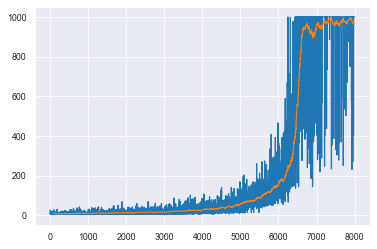

In [17]:
Iter=5000
for epoch in range(Iter):
    done=False
    s=env.reset()
    G=0
    gamma=1
    while not done:
        a = agent.get_actions(s.reshape(1,-1))
        sp, r, done, info = env.step(a[0])
        agent.update_paras(s.reshape(1,-1),a,r,sp.reshape(1,-1),done,gamma)
        gamma*=agent.gamma
        s = sp
        G+=r
    G_log.append(G)
    if (epoch+1)%50==0:
        print(len(G_log),np.mean(G_log[-50:]))
        plt.plot(G_log)
        plt.plot(pd.DataFrame(G_log).rolling(50).mean())
        plt.show()            

In [23]:
env.render()
s=env.reset()
done=False
G=0
while not done:
    a = agent.get_actions(s.reshape(1,-1))
    s, r, done, info = env.step(a[0])
    env.render() 
    G+=r
G

Creating window glfw


1000.0

In [24]:
agent.actor.eval()

Actor(
  (myparameters): ModuleList(
    (0): Linear(in_features=4, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=1, bias=True)
    (3): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [26]:
T.save(agent.actor.state_dict(), "CartP_actor")
# agent.actor.load_state_dict(torch.load("CartP_actor"))
# agent.actor.eval()